In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append("..")

from utils.utils import *
plt.rcParams['figure.figsize'] = (12,4)

In [2]:
def preprocess_acheron(df):
    dot = ['Black Swan', 'Guinafen', 'Luka', 'Sampo'] # Didn't consider Jiaoqiu as I want to  focus solely on Jiaoqiu's performance not Dot performance
    
    acheron = df.copy()
    acheron = df[df['team_leader'] == "Acheron"].copy().dropna()
    acheron['has_lc'] = acheron['weapon'] == "Along the Passing Shore"
    acheron['has_jiaoqiu'] = acheron['team_comp'].str.contains('Jiaoqiu')
    acheron['has_both'] = acheron['has_lc'] * acheron['has_jiaoqiu']

    acheron['dot_count'] = acheron['team_comp'].apply(lambda a: sum(name in a for name in dot))
    acheron['has_kafka'] = acheron['team_comp'].str.contains('Kafka')
    acheron['has_dot_combo'] = acheron['has_kafka'] & (acheron['dot_count'] > 0) # separate dot from normal cases as some buffs enhances DoT
    
    
    acheron['team_leader_adj'] = np.where(acheron['has_lc'], 'S1', 'S0')
    acheron['team_leader_adj'] = np.where(acheron['has_jiaoqiu'], acheron['team_leader_adj'] + ' X Jiaoqiu', acheron['team_leader_adj'])
    acheron['team_leader_adj'] = np.where(acheron['has_dot_combo'], acheron['team_leader_adj'] + ' X DoT', acheron['team_leader_adj'])
    return acheron, acheron.query('cons == 0'), acheron.query('cons == 2')

def get_usage_rate_by_version(df, character, plot=True, title=None):
    usage_rate = df.copy()
    usage_rate = usage_rate.groupby(['uid', 'version'])['team_comp'].agg(lambda x: (x.str.contains(character)).max()).reset_index()
    usage_rate = usage_rate.groupby('version')['team_comp'].mean().mul(100).reset_index()
    usage_rate.columns = ['version', 'usage_rate']
    usage_rate = usage_rate.query('usage_rate > 0')

    if plot:
        sns.lineplot(x='version', y='usage_rate', data=usage_rate, marker='o')
        if title is None:
            plt.title(character + ' Usage Rate')
        else:
            plt.title(title)
        plt.ylabel('Usage Rate')
        plt.xlabel('')
        plt.ylim(0,)
        plt.show()
    else:
        return usage_rate

## Apocalyptic Shadow

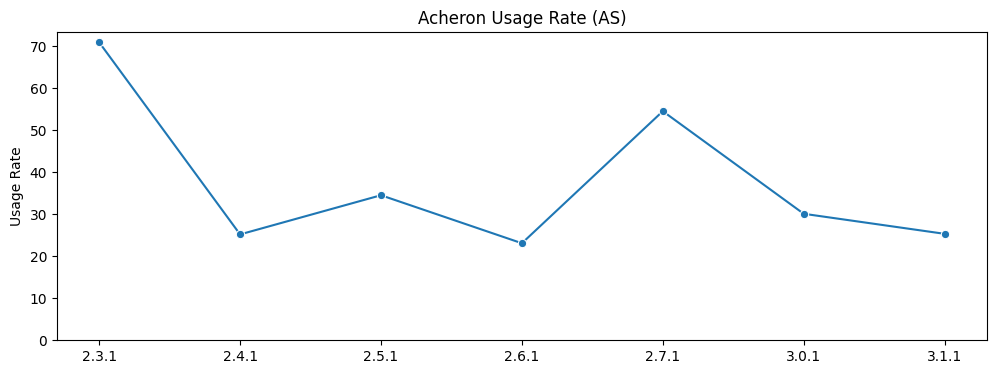

In [3]:
df = pd.read_csv("../data/as.csv")
df = df[df['version'].str[-1] == "1"]
apo, apo0, apo2 = preprocess_acheron(df)

get_usage_rate_by_version(df, 'Acheron', title='Acheron Usage Rate (AS)')

Text(0.5, 1.0, "E0 Acheron's Average Performance in Apocalyptic Shadow")

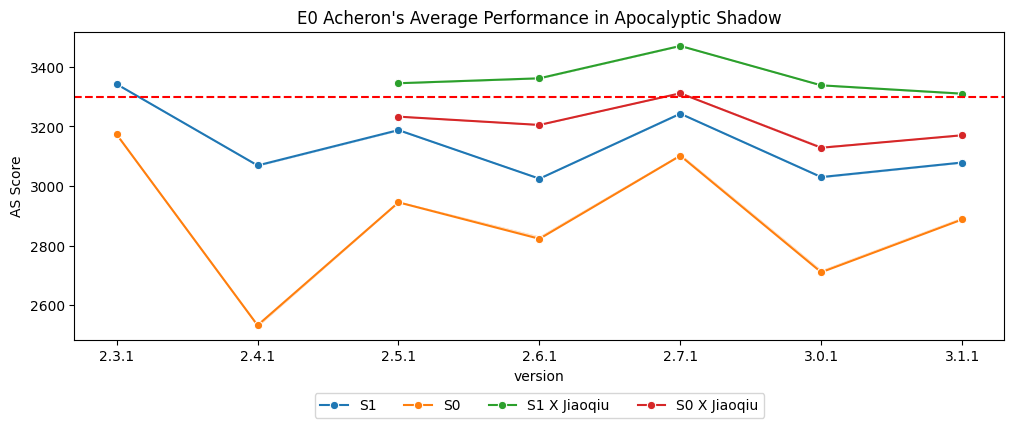

In [4]:
exclude_dot = apo0.query('~has_dot_combo')

plt.figure(figsize=(12,4))
sns.lineplot(x='version', y='round_num', hue='team_leader_adj', data=exclude_dot, marker='o', errorbar=('ci', False))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.ylabel('AS Score')
plt.axhline(y=3300, color='red', linestyle='dashed')
plt.title("E0 Acheron's Average Performance in Apocalyptic Shadow")

Text(0.5, 1.0, "E2 Acheron's Average Performance in Apocalyptic Shadow")

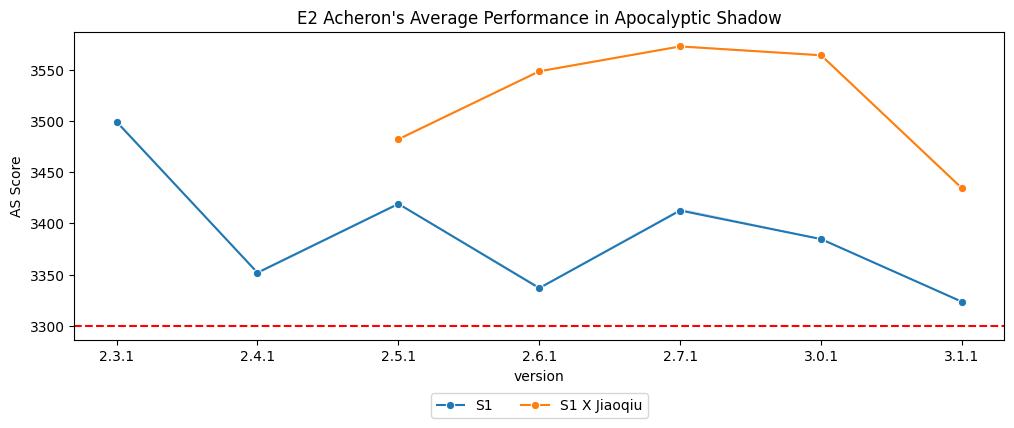

In [5]:
plt.figure(figsize=(12,4))
sns.lineplot(x='version', y='round_num', hue='team_leader_adj', data=apo2.query('has_lc & ~has_dot_combo'), marker='o', errorbar=('ci', False))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.ylabel('AS Score')
plt.axhline(y=3300, color='red', linestyle='dashed')
plt.title("E2 Acheron's Average Performance in Apocalyptic Shadow")

## Pure Fiction

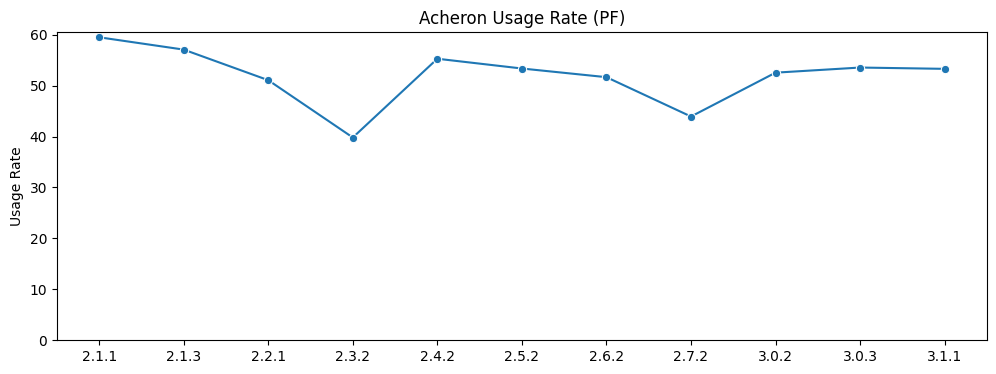

In [6]:
df = pd.read_csv("../data/pf.csv")
pf, e0_only, e2_only = preprocess_acheron(df)

get_usage_rate_by_version(df, 'Acheron', title='Acheron Usage Rate (PF)')

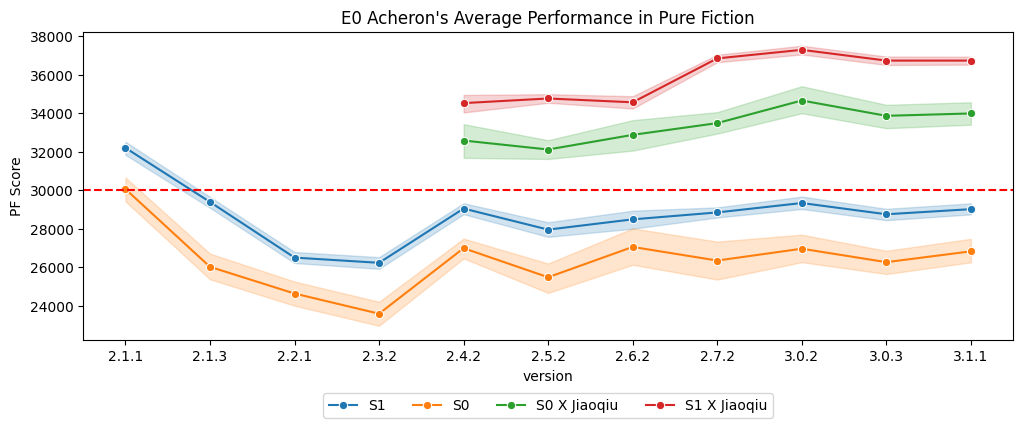

In [7]:
exclude_dot = e0_only.query('~has_dot_combo')

plt.figure(figsize=(12,4))
sns.lineplot(x='version', y='round_num', hue='team_leader_adj', data=exclude_dot, marker='o')
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.ylabel('PF Score')
plt.title("E0 Acheron's Average Performance in Pure Fiction")
plt.axhline(y=30000, color='red', linestyle='dashed')

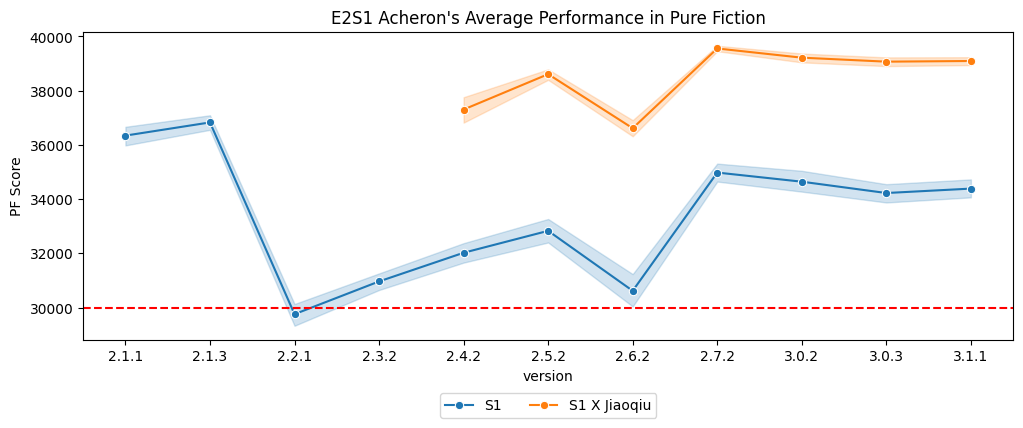

In [8]:
plt.figure(figsize=(12,4))
sns.lineplot(x='version', y='round_num', hue='team_leader_adj', data=e2_only.query('has_lc & ~has_dot_combo'), marker='o')
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.ylabel('PF Score')
plt.title("E2S1 Acheron's Average Performance in Pure Fiction")
plt.axhline(y=30000, color='red', linestyle='dashed')

## Are Eidolons worth? (Assuming we have Jiaoqiu + LC)

In [9]:
wjiaoqiu = apo.query('has_both').query('cons <=2 | cons == 6')
wjiaoqiu_pf  = pf.query('has_both').query('cons <=2 | cons == 6')

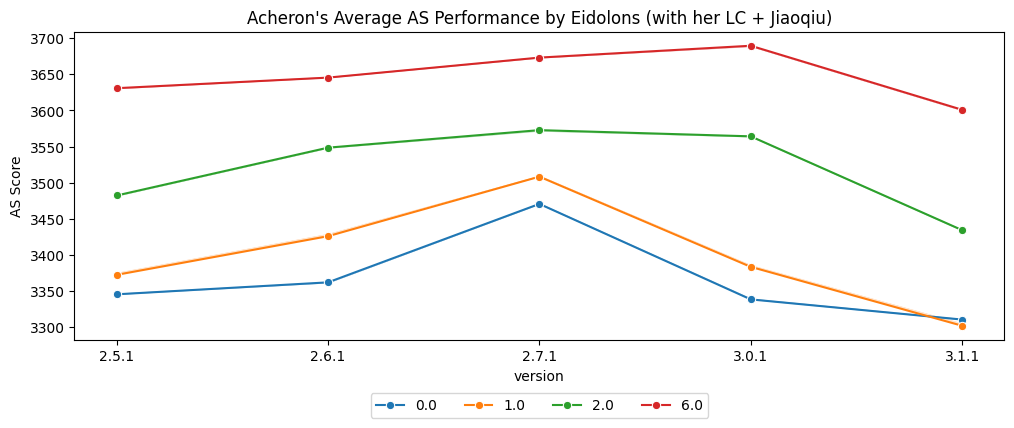

In [59]:
sns.lineplot(x='version', y='round_num', hue='cons', data=wjiaoqiu, marker='o', errorbar=('ci', False), palette='tab10')
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)

plt.title("Acheron's Average AS Performance by Eidolons (with her LC + Jiaoqiu)")
plt.ylabel("AS Score")
plt.show()

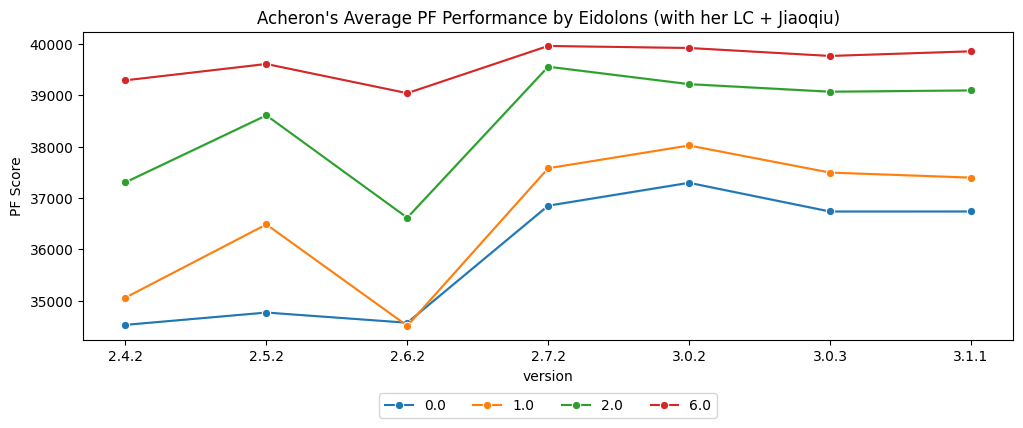

In [60]:
sns.lineplot(x='version', y='round_num', hue='cons', data=wjiaoqiu_pf, marker='o', errorbar=('ci', False), palette='tab10')
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)

plt.title("Acheron's Average PF Performance by Eidolons (with her LC + Jiaoqiu)")
plt.ylabel("PF Score")
plt.show()

## Compare with other chars at C0

In [49]:
df = pd.read_csv("../data/as.csv") 
df = df[df['version'].str[-1] == "1"]
df = df[df['team_leader'].isin(['Firefly', 'Feixiao', 'The Herta', 'Aglaea'])].query('cons == 0')
df['team_leader_display'] =  df['team_leader'] + ' E' +  df['cons'].astype('int').astype('str')

others = df.groupby(['version','team_leader_display'])['round_num'].mean().reset_index()

In [47]:
acheron = pd.concat([apo0, apo2]).query('~has_dot_combo & has_lc')
acheron['team_leader_display'] = 'Acheron E' + acheron['cons'].astype('int').astype('str') + acheron['team_leader_adj']
acheron = acheron.groupby(['version','team_leader_display'])['round_num'].mean().reset_index()

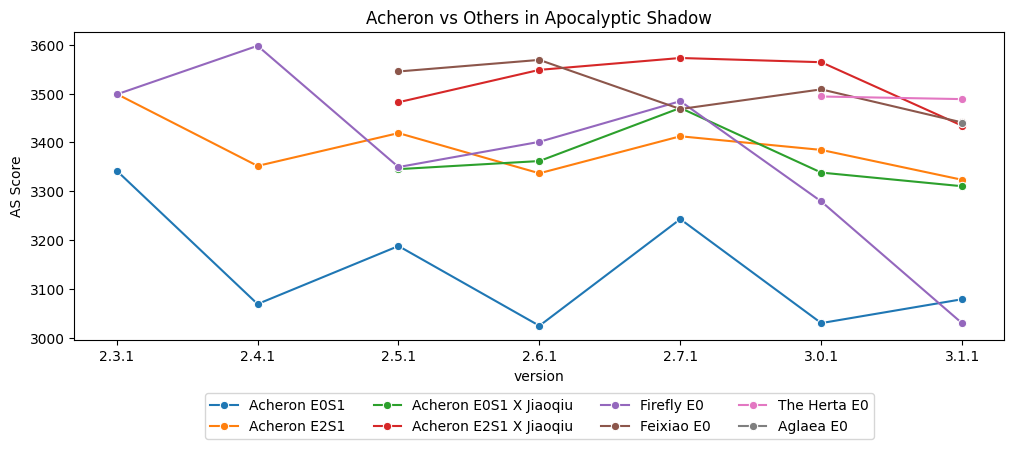

In [58]:
evaluation = pd.concat([acheron, others])

sns.lineplot(x='version', y='round_num', hue='team_leader_display', data=evaluation, marker='o')
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.title('Acheron vs Others in Apocalyptic Shadow')
plt.ylabel('AS Score')
plt.show()